In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/homedirs/yuny/project-1/audio_classification"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

pkg_path = "/nfs/homedirs/yuny/project-1/foolbox"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import os
import yaml
import torch
from audio_classification.tools import attack_model, attack_model_for_randomize_smoothing
from audio_classification.tools.foolbox_attack import attack_model_per_class

torch.cuda.empty_cache()
# device = torch.device('cpu')
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
project_dir = '/nfs/homedirs/yuny/project-1/'
save_folder = '/nfs/homedirs/yuny/project-1/attack_results/'

{'ATTACK': True, 'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k-verify-baseline', 'SAVE_PATH': '../weights/us8k', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '../datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'AUGMENTATION': 'none', 'FILE_PATH': '../datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': False}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/us8k/', 'MAX_EPOCH': 125, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 1, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.01}, 'TRANSFORM': {'HOP_LENGTH': 256}}
Range of the input data is (-1.000000, 1.000000)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 398.09 seconds
[0.4175, 0.27, 0.27375000000000005, 0.27249999999999996, 0.26125, 0.27375000000000005, 0.25875000000000004, 0.26375000000000004, 0.27875000000000005, 0.27249999999999996, 0.24875000000000003, 0.25249999999999995, 0.235, 0.24875000000000003, 0.23124999999999996, 0.235, 0.22750000000000004, 0.23750000000000004, 0.22875, 0.22124999999999995]


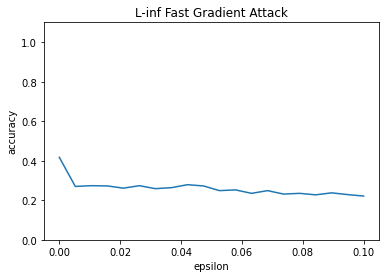

In [2]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 0.1
title = 'us8k_baseline'
config_path = 'logs/us8k/crnn-us8k-verify-baseline/version_0/hparams.yaml'
pretrained_path = 'weights/us8k/crnn-us8k-verify-baseline-epoch=58-val_acc=0.784.ckpt'
attack_model(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k-audio-rs-0.005', 'SAVE_PATH': '../weights/us8k/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '../datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'AUGMENTATION': 'none', 'FILE_PATH': '../datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/us8k/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.005, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.01}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Range of the input data is (-1.000000, 1.000000)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 4018.25 seconds
[0.64, 0.45375, 0.355, 0.31999999999999995, 0.30625, 0.29000000000000004, 0.28, 0.275, 0.26749999999999996, 0.26249999999999996, 0.25875000000000004, 0.25125, 0.24624999999999997, 0.235, 0.23124999999999996, 0.22750000000000004, 0.21875, 0.21250000000000002, 0.20499999999999996, 0.20125000000000004]


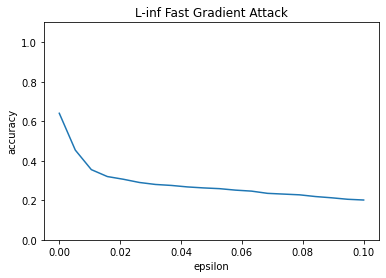

In [3]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 0.1
title = 'us8k_audio_rs_0.005'
config_path = 'logs/us8k/crnn-us8k-audio-rs-0.005/version_0/hparams.yaml'
pretrained_path = 'weights/us8k/crnn-us8k-audio-rs-0.005-epoch=68-val_acc=0.791.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k-audio-rs-0.01', 'SAVE_PATH': '../weights/us8k/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '../datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'AUGMENTATION': 'none', 'FILE_PATH': '../datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/us8k/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.01, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.01}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Range of the input data is (-1.000000, 1.000000)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 4007.99 seconds
[0.605, 0.48875, 0.41625, 0.38375000000000004, 0.345, 0.3325, 0.3275, 0.3125, 0.2975, 0.29125, 0.28, 0.27375000000000005, 0.26625, 0.25875000000000004, 0.24875000000000003, 0.24250000000000005, 0.23750000000000004, 0.22750000000000004, 0.21625000000000005, 0.20625000000000004]


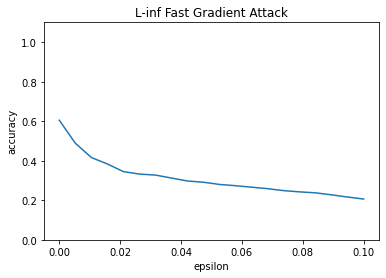

In [4]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 0.1
title = 'us8k_audio_rs_0.01'
config_path = 'logs/us8k/crnn-us8k-audio-rs-0.01/version_0/hparams.yaml'
pretrained_path = 'weights/us8k/crnn-us8k-audio-rs-0.01-epoch=107-val_acc=0.789.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k-audio-rs-0.05', 'SAVE_PATH': '../weights/us8k/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '../datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'AUGMENTATION': 'none', 'FILE_PATH': '../datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/us8k/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.05, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.01}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Range of the input data is (-1.000000, 1.000000)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 4014.18 seconds
[0.15874999999999995, 0.15125, 0.14500000000000002, 0.13875000000000004, 0.135, 0.12749999999999995, 0.125, 0.12, 0.11875000000000002, 0.11499999999999999, 0.11124999999999996, 0.11250000000000004, 0.10875000000000001, 0.10750000000000004, 0.10375000000000001, 0.10375000000000001, 0.10375000000000001, 0.10250000000000004, 0.10250000000000004, 0.10250000000000004]


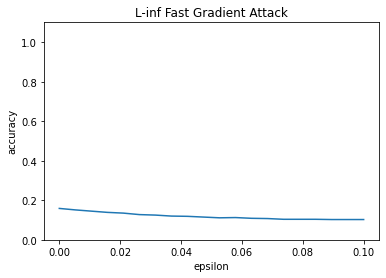

In [5]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 0.1
title = 'us8k_audio_rs_0.05'
config_path = 'logs/us8k/crnn-us8k-audio-rs-0.05/version_0/hparams.yaml'
pretrained_path = 'weights/us8k/crnn-us8k-audio-rs-0.05-epoch=129-val_acc=0.701.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw-audio-rs-0.005', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'AUGMENTATION': 'none', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'NAME': 'BMW', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 1, 'WEIGHT': 'NORMAL'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 6}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/bmw/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.005, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.001}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Data augmentation for BMW dataset: none
Range of the input data is (-1.000000, 0.999969)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3] tensor([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
       device='cuda:0')
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3] tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
[3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2] tensor([3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5],
       device='cuda:0')
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3] tensor([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
       device='cuda:0')
[3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3] tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
[3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2] tensor([3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5],
       device='cuda:0')
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3] tensor([0, 0, 1

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3] tensor([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
       device='cuda:0')
[2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3] tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
[2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2] tensor([3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5],
       device='cuda:0')
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3] tensor([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
       device='cuda:0')
[2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3] tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0')
[2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2] tensor([3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5],
       device='cuda:0')
Generated attacks in 590.21 seconds
[0.6333333333333333, 0.6, 0.566666666666

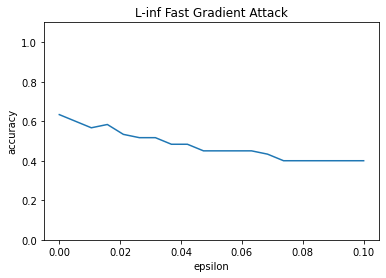

In [2]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 0.1
title = 'bmw_audio_rs_0.005'
config_path = 'logs/bmw/crnn-bmw-audio-rs-0.005/version_0/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-audio-rs-0.005-epoch=31-val_acc=1.000.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw-audio-rs-0.01', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'AUGMENTATION': 'none', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'NAME': 'BMW', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 1, 'WEIGHT': 'NORMAL'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 6}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/bmw/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.01, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.001}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Data augmentation for BMW dataset: none
Range of the input data is (-1.000000, 0.999969)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 583.49 seconds
[0.6333333333333333, 0.6, 0.5666666666666667, 0.55, 0.5333333333333333, 0.5166666666666666, 0.5166666666666666, 0.4833333333333333, 0.4666666666666667, 0.4666666666666667, 0.44999999999999996, 0.44999999999999996, 0.44999999999999996, 0.43333333333333335, 0.43333333333333335, 0.41666666666666663, 0.4, 0.3833333333333333, 0.3833333333333333, 0.3833333333333333]


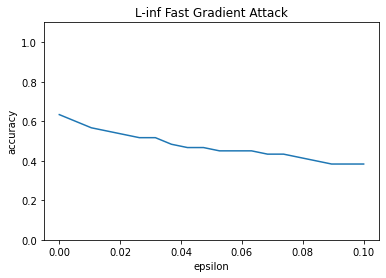

In [2]:
project="BMW"
max_rad = 0.1
title = 'bmw_audio_rs_0.01'
config_path = 'logs/bmw/crnn-bmw-audio-rs-0.01/version_0/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-audio-rs-0.01-epoch=90-val_acc=0.951.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw-audio-rs-1-new', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'AUGMENTATION': 'none', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'NAME': 'BMW', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 1, 'WEIGHT': 'NORMAL'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 6}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/bmw/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.05, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.001}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Data augmentation for BMW dataset: none
Range of the input data is (-1.000000, 0.999969)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 583.63 seconds
[0.5, 0.5, 0.5, 0.4833333333333333, 0.4833333333333333, 0.4833333333333333, 0.4833333333333333, 0.44999999999999996, 0.43333333333333335, 0.43333333333333335, 0.41666666666666663, 0.41666666666666663, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3833333333333333]


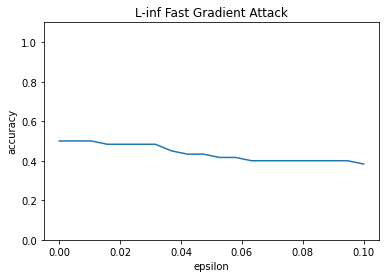

In [3]:
project="BMW"
max_rad = 0.1
title = 'bmw_audio_rs_0.05'
config_path = 'logs/bmw/crnn-bmw-audio-rs-1-new/version_1_rs_0.05/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-audio-rs-0.05-epoch=71-val_acc=0.934.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw-verify-baseline', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'AUGMENTATION': 'none', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'NAME': 'BMW', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 1, 'WEIGHT': 'NORMAL'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': False}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 6}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/bmw/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.25, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.001}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Data augmentation for BMW dataset: none
Range of the input data is (-1.000000, 0.999969)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 86.90 seconds
[0.9666666666666667, 0.6666666666666667, 0.65, 0.6166666666666667, 0.5833333333333333, 0.6, 0.6166666666666667, 0.6, 0.5833333333333333, 0.6, 0.6166666666666667, 0.6166666666666667, 0.5666666666666667, 0.5666666666666667, 0.5833333333333333, 0.55, 0.5166666666666666, 0.5166666666666666, 0.5, 0.5]


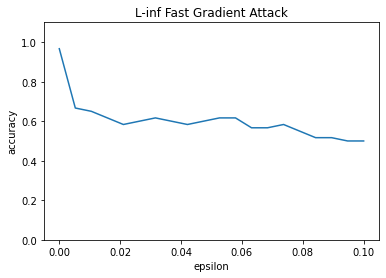

In [2]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 0.1
title = 'bmw_audio_verify_baseline'
config_path = 'logs/bmw/crnn-bmw-verify-baseline/version_0/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-verify-baseline-epoch=100-val_acc=0.984.ckpt'
attack_model(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

In [4]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 0.1
title = 'bmw_audio_verify_baseline'
config_path = 'logs/bmw/crnn-bmw-verify-baseline/version_0/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-verify-baseline-epoch=100-val_acc=0.984.ckpt'
class_count, is_adv_count = attack_model_per_class(project_dir, config_path, pretrained_path, project=project, attack_type = 'linf', epsilon=0.05)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-bmw-verify-baseline', 'SAVE_PATH': '../weights/bmw/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 8, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv', 'AUGMENTATION': 'none', 'FOLDER_PATH': '/nfs/students/winter-term-2020/project-1/datasets/Brake_Noise', 'NAME': 'BMW', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 1, 'WEIGHT': 'NORMAL'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': False}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 6}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/bmw/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.25, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.001}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Data augmentation for BMW dataset: none
Range of the input data is (-1.000000, 0.999969)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Per class freeuncy of prediction class from adversarial samples:
{0: {1: 1, 2: 1},
 1: {1: 1, 2: 2, 5: 1},
 2: {2: 13},
 3: {0: 1, 2: 3, 3: 20},
 4: {1: 1, 2: 13},
 5: {2: 1, 5: 2}}
Per class freeuncy of sucessful attacks from adversarial samples:
{0: {'True': 2},
 1: {'False': 1, 'True': 3},
 2: {'False': 13},
 3: {'False': 20, 'True': 4},
 4: {'True': 14},
 5: {'False': 2, 'True': 1}}


In [ ]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 0.1
# BMW(val_fold=1, uniform transform, no ls)
title = 'bmw_no_ls_no_weight_uniform_transform'
config_path = 'logs/bmw/default/crnn-bmw-uniform-epoch=42-val_acc=0.967/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-uniform-epoch=42-val_acc=0.967.ckpt'
class_count, is_adv_count = attack_model_per_class(project_dir, config_path, pretrained_path, project=project, attack_type = 'linf', epsilon=0.05)